In [8]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torch.nn.functional as F
import time
import models
from utils import logger, write_log
torch.backends.cudnn.benchmark=True
from glob import glob
import importlib
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from models import DFFNet
from dataloader import FoD500Loader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model = DFFNet(clean=False,level=4, use_diff=True)
model = nn.DataParallel(model)
model.cuda()

DataParallel(
  (module): DFFNet(
    (feature_extraction): FeatExactor(
      (encoder): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3

In [6]:
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))
loadmodel='/scratch/lnw8px/depth-from-Focus-Defocus/models/DFV/FoD500_DDFF12_scale0.2_nsck5_lr0.0001_ep700_b20_lvl4_diffFeat1/best.tar'
pretrained_dict = torch.load(loadmodel)
pretrained_dict['state_dict'] =  {k:v for k,v in pretrained_dict['state_dict'].items()  } #if ('disp' not in k)
model.load_state_dict(pretrained_dict['state_dict'],strict=False)

if 'epoch' in pretrained_dict:
    start_epoch = pretrained_dict['epoch']

if 'iters' in pretrained_dict:
    total_iter = pretrained_dict['iters']

if 'best' in pretrained_dict:
    best_loss = pretrained_dict['best']

if 'optimize' in pretrained_dict:
    optimizer.load_state_dict(pretrained_dict['optimize'])

print('load model from {}, start epoch {}, best_loss {}'.format(loadmodel, start_epoch, best_loss))

print('Number of model parameters: {}'.format(sum([p.data.nelement() for p in model.parameters()])))

load model from /scratch/lnw8px/depth-from-Focus-Defocus/models/DFV/FoD500_DDFF12_scale0.2_nsck5_lr0.0001_ep700_b20_lvl4_diffFeat1/best.tar, start epoch 561, best_loss 0.37800195813179016
Number of model parameters: 19501484


In [29]:
database = '/scratch/lnw8px/depth-from-Focus-Defocus/defocus-net/data/fs_6/'
FoD500_train, FoD500_val = FoD500Loader(database, n_stack=5, scale=1)
FoD500_train, FoD500_val =  [FoD500_train], [FoD500_val]
dataset_train = torch.utils.data.ConcatDataset(FoD500_train)
dataset_val = torch.utils.data.ConcatDataset(FoD500_val)
TrainImgLoader = torch.utils.data.DataLoader(dataset=dataset_train, num_workers=4, batch_size=6, shuffle=True, drop_last=True)
ValImgLoader = torch.utils.data.DataLoader(dataset=dataset_val, num_workers=1, batch_size=5, shuffle=False, drop_last=True)

In [54]:
for batch_idx, (img_stack_in, disp,coc_stack,foc_dist) in enumerate(TrainImgLoader):
    break
img_stack_in=Variable(torch.FloatTensor(img_stack_in))
gt_disp=Variable(torch.FloatTensor(disp))
img_stack,gt_disp,foc_dist,coc_stack=img_stack_in.cuda(),gt_disp.cuda(),foc_dist.cuda(),coc_stack.cuda()

In [55]:
coc_mean=torch.mean(coc_stack,dim=1)
coc_mean=torch.unsqueeze(coc_mean,dim=1)
coc_max=torch.max(coc_stack,dim=1).values
coc_max=torch.unsqueeze(coc_max,dim=1)
coc_min=torch.min(coc_stack,dim=1).values
coc_min=torch.unsqueeze(coc_min,dim=1)
coc_max=torch.repeat_interleave(coc_max,repeats=5,dim=1)
coc_min=torch.repeat_interleave(coc_min,repeats=5,dim=1)

coc_stack_norm=(coc_stack-coc_min)/(coc_max-coc_mean)

In [70]:
model.eval()
stacked=model(img_stack, foc_dist)
print(len(stacked))
stacked=stacked[0]
print(stacked.shape)
print(img_stack.shape)
print(gt_disp.shape)
print(coc_stack_norm.shape)

s_mean=torch.mean(stacked,dim=1)
s_mean=torch.unsqueeze(s_mean,dim=1)

s_max=torch.max(stacked,dim=1).values
s_max=torch.unsqueeze(s_max,dim=1)

s_min=torch.min(stacked,dim=1).values
s_min=torch.unsqueeze(s_min,dim=1)

s_max=torch.repeat_interleave(s_max,repeats=5,dim=1)
s_min=torch.repeat_interleave(s_min,repeats=5,dim=1)

s_norm=(stacked-s_min)/(s_max-s_min)

1
torch.Size([6, 5, 224, 224])
torch.Size([6, 5, 3, 224, 224])
torch.Size([6, 1, 224, 224])
torch.Size([6, 5, 224, 224])


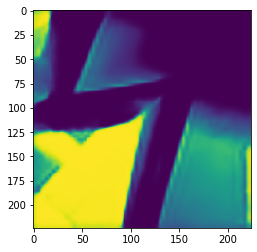

In [57]:
plt.imshow(stacked[0,0,:,:].cpu().detach().numpy())

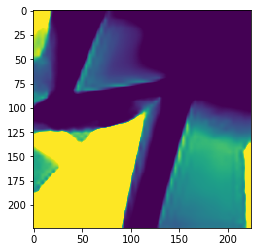

In [58]:
plt.imshow(s_norm[0,0,:,:].cpu().detach().numpy())

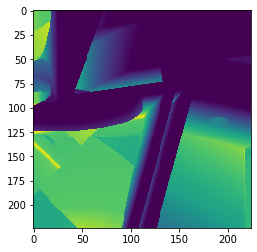

In [62]:
plt.imshow(coc_stack_norm[0,0,:,:].cpu().detach().numpy())

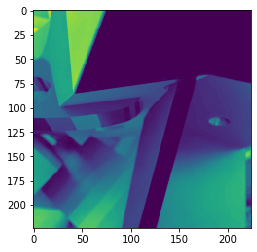

In [59]:
plt.imshow(img_stack[0,0,0,:,:].cpu().detach().numpy())

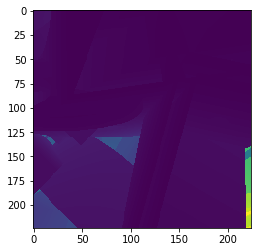

In [60]:
plt.imshow(gt_disp[0,0,:,:].cpu().detach().numpy())

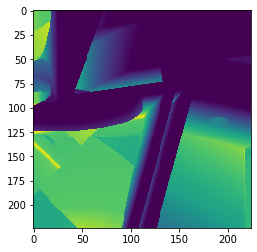